# Running Molecular Dynamics Simulations of Lennard-Jones systems in the canonical ensemble

Ralf Everaers, ENS Lyon (2021)

In the course I did not only want to explain some of the fundamental methods of Computational Statistical Mechanics, but I also wanted you to acquire a culture of running and analysing simulations.

The present notebook reviews the steps we have followed throughout the lecture for Exact/Multiparticle Collision Dynamics, Metropolis Monte Carlo and Molecular Dynamics. Here they are applied to MD simulations of LJ systems in the canonical NVT-ensemble with the objective to measure the equation of state $p(N,V,T)$.  

For this purpose, we require routines and data structures, which allow us

    1) to carry out individual runs
    2) to simulate ensembles of independent trajectories for identical values of (N,V,T)
    3) to sweep through parameter space for sampling data sets following different sequences of (N,V,T)
    4) to organise and automatically analyse ALL the acquired data 
    

In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import math
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

## Individual NVT-MD trajectories for a LJ systems

### A routine for generating or extending individual NVT-MD trajectories for a LJ systems

In [2]:
def Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                 starting_configuration=[],
                                                 time_step = 0.01,
                                                 number_of_time_steps_between_stored_configurations=100,
                                                 number_of_time_steps_between_velocity_resets=100,
                                                 debug=False):
    """
    generates a NVT MD simulations of a LJ system with sigma=epsilon=1  
        - where the particle masses are specified in the array m
        - so that NParticles = m.size
        - in a volume V=(LBox,LBox) at a specified temperature kT
        - with a time step of time_step tau 
          where the LJ unit of time is calculated as a function of m[-1], i.e. the mass of the LAST particle
        - runs are either started from 
                a specified starting configuration [t,x,y,vx,vy] or
                initialized with zero velocities and particles placed on a square grid
        - the simulations are thermostated by redrawing random velocities from the 
          Maxwell-Boltzmann distribution number_of_time_steps_between_velocity_resets time steps
        - the function returns 
                trajectory lists t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr 
                     of sampling times and sampled coordinates, velocities and energies and pressures
                a final configuration [t,x,y,vx,vy] from which the run can be restarted
                while the energies and pressures are recorded at every time step, configurations 
                     and velocities are stored at a time interval of time_between_stored_configurations
                    
    """

    NParticles = m.size
    sigma = 1
    epsilon = 1
    #unit of time
    tau = sigma*np.sqrt(m[-1]/epsilon)      

    # define the length of the trajectory
    number_of_timesteps = int(np.round(run_time/time_step))

    #starting configuration
    if starting_configuration!=[]:
        [t,x,y,vx,vy] = starting_configuration
    else:
        # default initial state
        x,y = MD.GridPositionsIn2d(LBox,LBox,NParticles)
        vx = MD.RandomVelocities(m,kT)
        vy = MD.RandomVelocities(m,kT)
        t = 0
        if debug:
            print("No starting configuration")

    #initialize Trajectory
    t_tr = []
    x_tr = []
    vx_tr = []
    y_tr = []
    vy_tr = []

    fx,fy = MD.LJ_forces_as_a_function_of_positions(d,epsilon,sigma,LBox,(x,y))
    # force for initial configuration needed for first time step

    for timestep in range(number_of_timesteps):
        (x,y),(vx,vy) = MD.VelocityVerletTimeStepPartOne(m,(x,y),(vx,vy),(fx,fy),time_step)
        fx,fy = MD.LJ_forces_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
        (x,y),(vx,vy) = MD.VelocityVerletTimeStepPartTwo(m,(x,y),(vx,vy),(fx,fy),time_step)
        t += time_step
        
        t_tr.append(t)
        x_tr.append(x)
        vx_tr.append(vx)
        y_tr.append(y)
        vy_tr.append(vy)
    
        # thermostat: reinitialise velocities to control temperature
#        if np.mod( timestep*time_step, time_between_velocity_resets ) == 0.0 and timestep>1:
        if timestep%number_of_time_steps_between_velocity_resets == 0 and timestep>1:
            vx = MD.RandomVelocities(m,kT)
            vy = MD.RandomVelocities(m,kT)

    # convert trajectory lists to arrays to simplify the data analysis
    t_tr = np.array(t_tr)
    x_tr = np.array(x_tr)
    vx_tr = np.array(vx_tr)
    y_tr = np.array(y_tr)
    vy_tr = np.array(vy_tr)

    # analyse results 
    uPot_tr = MD.LJ_energy_as_a_function_of_positions(d,epsilon,sigma,LBox,(x_tr,y_tr))
    uKin_tr = MD.TotalKineticEnergy(m,vx_tr) + MD.TotalKineticEnergy(m,vy_tr)
    pPot_tr = MD.LJ_virial_pressure_as_a_function_of_positions(d,epsilon,sigma,LBox,(x_tr,y_tr)) 
    pKin_tr = MD.KineticPressure_as_a_function_of_velocities(d,LBox,m,(vx_tr,vy_tr))
    
    # reduce the number of stored configurations and velocities
#    skip = int(time_between_stored_configurations / delta_t)
    skip = number_of_time_steps_between_stored_configurations
    x_tr = x_tr[::skip]
    y_tr = y_tr[::skip]
    vx_tr = vx_tr[::skip]
    vy_tr = vy_tr[::skip]    
    # note that t_tr is not compressed as it contains the times corresponding to the stored energies and pressures
    # as a consequence a corresponding skipping operation needs to be performed, when configurations are plotted 
    # as a function of time
    
    return t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, [t,x,y,vx,vy]

### A first trajectory for a 2d LJ system

In [3]:
# define system
d=2
NParticles=64
kT = 0.7
m = np.ones(NParticles)

# Lennard-Jones
sigma = 1
epsilon = 1
tau = sigma*np.sqrt(m[0]/epsilon) #unit of time     

# choose density
rho = 0.5/sigma**d
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 50. * tau

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

( t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, [t,x,y,vx,vy] 
) = Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

LBox =  11.313708498984761
Execution time:  27.828740887000095


In [4]:
x_tr[-1,0:10]

array([ 1.48488547,  2.10115138, -0.73004797,  4.07528837,  3.3980854 ,
        5.83857449,  8.18674522, 12.25241543,  1.58798919,  3.94871259])

In [5]:
x_tr[-1,0:10]

array([ 1.48488547,  2.10115138, -0.73004797,  4.07528837,  3.3980854 ,
        5.83857449,  8.18674522, 12.25241543,  1.58798919,  3.94871259])

We can animate at the stored configurations ....

102


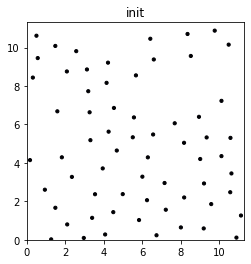

In [6]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but onfigurations were stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
skip=int( (t_tr.size-1)/(x_tr.shape[0]-1) )
print(skip)

MD.AnimateMDRun(t_tr[::skip],x_tr,y_tr,xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

... look at the trajectories of individual particles ...

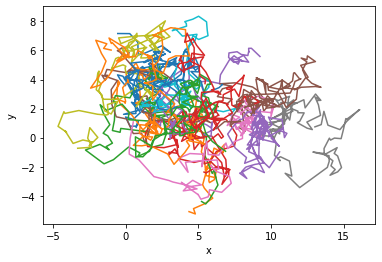

In [36]:
ax = plt.axes()
MD.AddParticleTraces(ax,x_tr,y_tr,range(NParticles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

... inspect the time evolution of the pressure ...

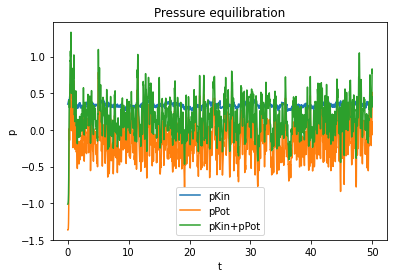

In [8]:
plt.plot(t_tr,pKin_tr,label="pKin")
plt.plot(t_tr,pPot_tr,label="pPot")
plt.plot(t_tr,pKin_tr+pPot_tr,label="pKin+pPot")
plt.xlabel("t")
plt.ylabel("p")
plt.title("Pressure equilibration")
plt.legend()

... and of the internal energy and its components:

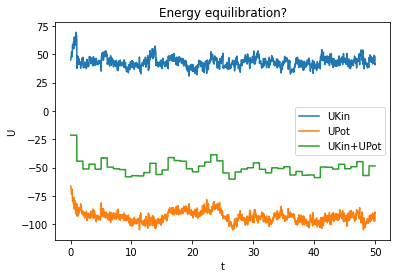

In [9]:
plt.plot(t_tr,uKin_tr,label="UKin")
plt.plot(t_tr,uPot_tr,label="UPot")
plt.plot(t_tr,uKin_tr+uPot_tr,label="UKin+UPot")
plt.xlabel("t")
plt.ylabel("U")
plt.title("Energy equilibration?")
plt.legend()

#### Why is the total energy not constant?

Ce sont les effets de températures qui agissent sur le système.

### Extending runs

Runs can be retarted from the previous final configuration. Here I have increased the time between thermostatting events so much, that the second half of the trajectories is essentially an NVE-run in the microcanonical ensemble.

In [39]:
# generate trajectory and measure execution time
initialWallTime = time.perf_counter()

( new_t_tr, new_x_tr, new_y_tr, new_vx_tr, new_vy_tr, new_uPot_tr, new_uKin_tr, new_pPot_tr, new_pKin_tr, [t,x,y,vx,vy] 
) = Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                 starting_configuration=[t,x,y,vx,vy],
                                                 number_of_time_steps_between_velocity_resets=10000)

print("Execution time: ",time.perf_counter() - initialWallTime)

ValueError: operands could not be broadcast together with shapes (2,64) (16,) 

#### Plot the old data for the energy together with the new data

In [ ]:
plt.plot(t_tr,uKin_tr,label="UKin")
plt.plot(t_tr,uPot_tr,label="UPot")
plt.plot(t_tr,uKin_tr+uPot_tr,label="UKin+UPot")
plt.plot(new_t_tr,new_uKin_tr,label="UKin")
plt.plot(new_t_tr,new_uPot_tr,label="UPot")
plt.plot(new_t_tr,new_uKin_tr+new_uPot_tr,label="UKin+UPot")
plt.xlabel("t")
plt.ylabel("U")
plt.title("Energy conservation")
plt.legend()

It is worth taking a closer look at the total energy in this second part:

In [ ]:
plt.plot(new_t_tr,new_uKin_tr+new_uPot_tr,label="UKin+UPot")
plt.xlabel("t")
plt.ylabel("U")
plt.title("Energy conservation")
plt.legend()

#### The total energy is NOT constant. Yet there is no long-term drift. Why?

A cause de Verlet.

All that is left to do is to concatenate the output of the first and the second run:

In [ ]:
t_tr = np.concatenate((t_tr,new_t_tr))
x_tr = np.concatenate((x_tr,new_x_tr))
y_tr = np.concatenate((y_tr,new_y_tr))
vx_tr = np.concatenate((vx_tr,new_vx_tr))
vy_tr = np.concatenate((vy_tr,new_vy_tr))
uKin_tr = np.concatenate((uKin_tr,new_uKin_tr))
uPot_tr = np.concatenate((uPot_tr,new_uPot_tr))
pKin_tr = np.concatenate((pKin_tr,new_pKin_tr))
pPot_tr = np.concatenate((pPot_tr,new_pPot_tr))

#### Plot the aggregate data for the energy

In [ ]:
plt.plot(t_tr,uKin_tr,label="UKin")
plt.plot(t_tr,uPot_tr,label="UPot")
plt.plot(t_tr,uKin_tr+uPot_tr,label="UKin+UPot")
plt.xlabel("t")
plt.ylabel("U")
plt.title("Energy conservation")
plt.legend()

## A routine for generating or extending an ensemble of NVT-MD trajectories for LJ systems

In [15]:
def Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,run_time,
                                                               list_of_starting_configurations=[],
                                                               time_step=0.01,
                                                               number_of_time_steps_between_stored_configurations=100,
                                                               number_of_time_steps_between_velocity_resets=100,
                                                               debug=False):
    """
    uses Generate_LJ_NVT_MolecularDynamics_Trajectory to

    generate an ensemble of NTrajectories NVT MD simulations of a LJ system with sigma=epsilon=1  
        - where the particle masses are specified in the array m
        - so that NParticles = m.size
        - in a volume V=(LBox,LBox) at a specified temperature kT
        - with a time step of time_step tau 
          where the LJ unit of time is calculated as a function of m[-1], i.e. the mass of the LAST particle
        - runs are either started from 
                a list of specified starting configuration [[t,x,y,vx,vy], ...] or
                initialized with zero velocities and particles placed on a square grid
        - the simulations are thermostated by redrawing random velocities from the 
          Maxwell-Boltzmann distribution at intervals of time_between_velocity_resets
        - the function returns 
                trajectory ensemble lists t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens, uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens 
                     of sampling times and sampled coordinates, velocities and energies and pressures
                a list of final configurations [[t,x,y,vx,vy], ...] from which the runs can be restarted
                while the energies and pressures are recorded at every time step, configurations 
                     and velocities are stored at a time interval of time_between_stored_configurations      
    """
    # initialize lists to collect ENSEMBLES of trajectories
    t_tr_ens = []
    x_tr_ens = []
    vx_tr_ens = []
    y_tr_ens = []
    vy_tr_ens = []
    uKin_tr_ens = []
    uPot_tr_ens = []
    pKin_tr_ens = []
    pPot_tr_ens = []
    
    # convert empty list into lists of NTrajectories empty lists, 
    # which can then by passed on to the simulation routine
    if list_of_starting_configurations==[]:
        local_list_of_starting_configurations=[]
        if debug:
            print("No list of starting configurations")
        for n in range(NTrajectories): 
            local_list_of_starting_configurations.append([])
    else:
        local_list_of_starting_configurations = list_of_starting_configurations

    for n in range(NTrajectories):
        if debug:
            print('.', end='', flush=True)
        (t_tr, x_tr, y_tr, vx_tr, vy_tr, 
         uPot_tr, uKin_tr, pPot_tr, pKin_tr, 
         local_list_of_starting_configurations[n]
        ) = Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time,
                                                         local_list_of_starting_configurations[n],
                                                         time_step=time_step,
                                                         number_of_time_steps_between_stored_configurations=number_of_time_steps_between_stored_configurations,
                                                         number_of_time_steps_between_velocity_resets=number_of_time_steps_between_velocity_resets)

        # append trajectories to corresponding ensemble lists
        t_tr_ens.append(t_tr)
        x_tr_ens.append(x_tr)
        vx_tr_ens.append(vx_tr)
        y_tr_ens.append(y_tr)
        vy_tr_ens.append(vy_tr)
        uKin_tr_ens.append(uKin_tr)
        uPot_tr_ens.append(uPot_tr)
        pKin_tr_ens.append(pKin_tr)
        pPot_tr_ens.append(pPot_tr)
    
    if debug:
        print("")
    t_tr_ens = np.array(t_tr_ens)
    x_tr_ens = np.array(x_tr_ens)
    y_tr_ens = np.array(y_tr_ens)
    vx_tr_ens = np.array(vx_tr_ens)
    vy_tr_ens = np.array(vy_tr_ens)
    uKin_tr_ens = np.array(uKin_tr_ens)
    uPot_tr_ens = np.array(uPot_tr_ens)
    pKin_tr_ens = np.array(pKin_tr_ens)
    pPot_tr_ens = np.array(pPot_tr_ens)
    
    return (t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens, 
            uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens, 
            local_list_of_starting_configurations)

In [16]:
# define system
NParticles=64
kT = 1
m = np.ones(NParticles)
sigma = 1
epsilon = 1
#unit of time
tau = sigma*np.sqrt(m[0]/epsilon)      

# density
rho = 0.5/sigma**3
LBox = np.power(NParticles/rho,1/2)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 5. * tau

# define number of independent trajectories
NTrajectories = 10

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

(t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
 uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens,
 list_of_starting_configurations
) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

LBox =  11.313708498984761
Execution time:  27.945811217000028


In [17]:
uKin_tr_ens.shape

(10, 500)

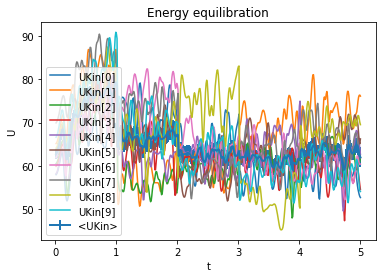

In [18]:
for n in range(NTrajectories):
    plt.plot(t_tr_ens[n],uKin_tr_ens[n],label="UKin["+str(n)+"]")

uKin_Tr = np.mean(uKin_tr_ens.transpose(),axis=-1)
uKin_Tr_error = np.std(uKin_tr_ens.transpose(),axis=-1)/np.sqrt(NTrajectories)

plt.errorbar(t_tr_ens[0],uKin_Tr,yerr=uKin_Tr_error,label="<UKin>", linewidth=2)

plt.xlabel("t")
plt.ylabel("U")
plt.title("Energy equilibration")
plt.legend()

Let's make sure that the total energy is conserved in between thermostatting events:

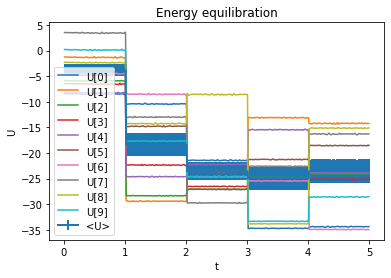

In [19]:
for n in range(NTrajectories):
    plt.plot(t_tr_ens[n],uKin_tr_ens[n]+uPot_tr_ens[n],label="U["+str(n)+"]")

uTot_Tr = np.mean(uKin_tr_ens.transpose()+uPot_tr_ens.transpose(),axis=-1) 
uTot_Tr_error = np.std(uKin_tr_ens.transpose() + uPot_tr_ens.transpose(),axis=-1) /np.sqrt(NTrajectories)

plt.errorbar(t_tr_ens[0],uTot_Tr,yerr=uTot_Tr_error,label="<U>", linewidth=2)

plt.xlabel("t")
plt.ylabel("U")
plt.title("Energy equilibration")
plt.legend()

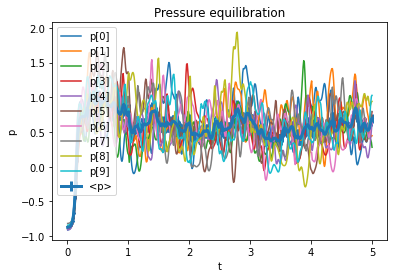

In [20]:
for n in range(NTrajectories):
    plt.plot(t_tr_ens[n],pKin_tr_ens[n]+pPot_tr_ens[n],label="p["+str(n)+"]")

pTot_Tr = np.mean(pKin_tr_ens.transpose()+pPot_tr_ens.transpose(),axis=-1) 
pTot_Tr_error = np.std(pKin_tr_ens.transpose() + pPot_tr_ens.transpose(),axis=-1) /np.sqrt(NTrajectories)

plt.errorbar(t_tr_ens[0],pTot_Tr,yerr=pTot_Tr_error,label="<p>", linewidth=3)

plt.xlabel("t")
plt.ylabel("p")
plt.title("Pressure equilibration")
plt.legend()

So we should at least dump data from the first few tau of our runs before averaging.

## Accumulating data and organising data sets for different (N,V,T)

In the following we will explore the behavior of 2d LJ systems for different combinations ot temperature $T$ and density $\rho = N/V$. Instead of always equilibrating from scratch, we will explore four different "sweeps" through the $(\rho,T)$-space:

    1) heating up systems prepared for a range of densities
    2) cooling down systems prepared for a range of densities
    3) expanding systems prepared for a range of temperatures
    4) compressing systems prepared for a range of temperatures
    
In the interest of time our runs below will be pretty short. But the comparision of results obtained from the four different sweeps will give us a pretty good idea if and if so where more efforts would be needed to produce proper data.

In [21]:
rho_range = np.concatenate((np.arange(0.05,0.125,0.025), np.arange(0.15,0.25,0.05),np.arange(0.25,0.55,0.1),np.arange(0.55,0.75,0.05),np.arange(0.75,0.95,0.025)))
print(rho_range)

[0.05  0.075 0.1   0.15  0.2   0.25  0.35  0.45  0.55  0.55  0.6   0.65
 0.7   0.75  0.775 0.8   0.825 0.85  0.875 0.9   0.925]


In [22]:
kT_range = np.array([0.25,0.35,0.5,0.7,1.0])

In [23]:
# When in doubt use a small number of particles to speed up the simulations
# In a perfect world (as opposed to an exam), we would generate data for different systems sizes 
# and study finite size effects.
NParticles = 16
m = np.ones(NParticles)
d = 2

# Not much fun, if we reduce this even further
NTrajectories = 5
run_time_equilibration = 2
run_time_data_acquisition = 3

print("One sweep over all state points corresponds to ", rho_range.size * kT_range.size * NTrajectories," separate simulations!")

# On my computer each of the for "sweeps" below took 2 minutes. If you are worried about time try first with
# NTrajectories = 1

One sweep over all state points corresponds to  525  separate simulations!


We better get organized to be able

    1) to run such a large number of simulations
    2) to analyze the results of all individual runs
    3) to plot ALL of the results together

### Heating up systems prepared for a range of densities

In [24]:
# Create empty dictionaries for the data generated by MD simulations at specific state points
t_tr_ens_from_NVT_heating = {}
x_tr_ens_from_NVT_heating = {}
y_tr_ens_from_NVT_heating = {}
vx_tr_ens_from_NVT_heating = {}
vy_tr_ens_from_NVT_heating = {}
uPot_tr_ens_from_NVT_heating = {}
uKin_tr_ens_from_NVT_heating = {}
pPot_tr_ens_from_NVT_heating = {}
pKin_tr_ens_from_NVT_heating = {}
list_of_starting_configurations_from_NVT_heating = {}


# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

# sweep over densities
for rho in rho_range:
    
    # re-initialize starting configurations
    list_of_starting_configurations=[]
    for n in range(NTrajectories): 
            list_of_starting_configurations.append([])    
    

    # sweep over temperatures
    for kT in kT_range:
        
        print("rho = ",rho,", kT = ",kT)
        
        # Box size
        LBox = np.power(NParticles/rho,1./d)


        # Equilibrate
        # ... reset velocities more often and hope for the best
        (t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
         uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens,
         list_of_starting_configurations
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_equilibration,
                                                                       list_of_starting_configurations=list_of_starting_configurations,
                                                                       number_of_time_steps_between_velocity_resets=10)

        key = (NParticles,str(round(rho,3)),str(round(kT,2)))
        # using floats as key can lead to difficulties, because of their inexact representation
        
                # Generate data
        run_time = 1  # outrageously short
        (t_tr_ens_from_NVT_heating[key], 
         x_tr_ens_from_NVT_heating[key], 
         y_tr_ens_from_NVT_heating[key], 
         vx_tr_ens_from_NVT_heating[key], 
         vy_tr_ens_from_NVT_heating[key],
         uPot_tr_ens_from_NVT_heating[key], 
         uKin_tr_ens_from_NVT_heating[key], 
         pPot_tr_ens_from_NVT_heating[key], 
         pKin_tr_ens_from_NVT_heating[key],
         list_of_starting_configurations_from_NVT_heating[key]
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_data_acquisition,
                                                                       list_of_starting_configurations=list_of_starting_configurations)
        

print("Execution time: ",time.perf_counter() - initialWallTime)

rho =  0.05 , kT =  0.25
rho =  0.05 , kT =  0.35
rho =  0.05 , kT =  0.5
rho =  0.05 , kT =  0.7
rho =  0.05 , kT =  1.0
rho =  0.07500000000000001 , kT =  0.25
rho =  0.07500000000000001 , kT =  0.35
rho =  0.07500000000000001 , kT =  0.5
rho =  0.07500000000000001 , kT =  0.7
rho =  0.07500000000000001 , kT =  1.0
rho =  0.10000000000000002 , kT =  0.25
rho =  0.10000000000000002 , kT =  0.35
rho =  0.10000000000000002 , kT =  0.5
rho =  0.10000000000000002 , kT =  0.7
rho =  0.10000000000000002 , kT =  1.0
rho =  0.15 , kT =  0.25
rho =  0.15 , kT =  0.35
rho =  0.15 , kT =  0.5
rho =  0.15 , kT =  0.7
rho =  0.15 , kT =  1.0
rho =  0.2 , kT =  0.25
rho =  0.2 , kT =  0.35
rho =  0.2 , kT =  0.5
rho =  0.2 , kT =  0.7
rho =  0.2 , kT =  1.0
rho =  0.25 , kT =  0.25
rho =  0.25 , kT =  0.35
rho =  0.25 , kT =  0.5
rho =  0.25 , kT =  0.7
rho =  0.25 , kT =  1.0
rho =  0.35 , kT =  0.25
rho =  0.35 , kT =  0.35
rho =  0.35 , kT =  0.5
rho =  0.35 , kT =  0.7
rho =  0.35 , kT =  1.0
r

#### Pressure isotherms

A very useful trick when it comes to plotting data as a function of $\rho$ or $T$ is to filter our dictionaries:

https://thispointer.com/python-filter-a-dictionary-by-conditions-on-keys-or-values/


In [25]:
def filterTheDict(dictObj, callback):
    '''
    Iterate over all the keys in dictionary and call the given callback function() on each key. 
    Add items for which callback() returns True to a new dictionary. 
    In the end return the new dictionary.
    '''
    newDict = dict()
    # Iterate over all the items in dictionary
    for key in dictObj.keys():
        # Check if item satisfies the given condition then add to new dict
        if callback(key):
            newDict[key] = dictObj[key]
    return newDict

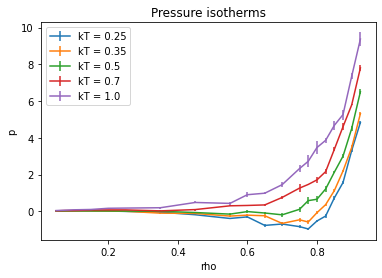

In [26]:
# remember that the keys are stored as strings

# sweep over temperatures
for kT in kT_range:
        
    filtered_pPot_tr_ens = filterTheDict(pPot_tr_ens_from_NVT_heating,lambda key : key[2]==str(round(kT,3)) )
    filtered_pKin_tr_ens = filterTheDict(pKin_tr_ens_from_NVT_heating,lambda key : key[2]==str(round(kT,3)) )
    
    rho_list = []
    p_list = []
    p_error_list = []
    
    for key in sorted(filtered_pPot_tr_ens):
            
        rho_list.append(float(key[1]))
        
        # time average over runs followed by the ensemble average
        p_list.append(
            np.mean(
                np.mean(filtered_pPot_tr_ens[key] +
                        filtered_pKin_tr_ens[key],axis=-1) ) )
        p_error_list.append(
            np.std(
                np.mean(filtered_pPot_tr_ens[key] +
                        filtered_pKin_tr_ens[key],axis=-1) ) / np.sqrt(NTrajectories))
            
    plt.errorbar(rho_list,p_list,yerr=p_error_list,label="kT = "+str(kT))

plt.xlabel("rho")
plt.ylabel("p")
plt.title("Pressure isotherms")
plt.legend()

### Cooling down systems prepared for a range of densities

In [27]:
np.flipud(kT_range)

array([1.  , 0.7 , 0.5 , 0.35, 0.25])

In [28]:
# Create empty dictionaries for the data generated by MD simulations at specific state points
t_tr_ens_from_NVT_cooling = {}
x_tr_ens_from_NVT_cooling = {}
y_tr_ens_from_NVT_cooling = {}
vx_tr_ens_from_NVT_cooling = {}
vy_tr_ens_from_NVT_cooling = {}
uPot_tr_ens_from_NVT_cooling = {}
uKin_tr_ens_from_NVT_cooling = {}
pPot_tr_ens_from_NVT_cooling = {}
pKin_tr_ens_from_NVT_cooling = {}
list_of_starting_configurations_from_NVT_cooling = {}


# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

# sweep over densities
for rho in rho_range:
    
    # re-initialize starting configurations
    list_of_starting_configurations=[]
    for n in range(NTrajectories): 
            list_of_starting_configurations.append([])    
    

    # sweep over temperatures
    for kT in np.flipud(kT_range):
        
        print("rho = ",rho,", kT = ",kT)
        
        # Box size
        LBox = np.power(NParticles/rho,1./d)


        # Equilibrate
        # ... reset velocities more often and hope for the best
        (t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
         uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens,
         list_of_starting_configurations
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_equilibration,
                                                                       list_of_starting_configurations=list_of_starting_configurations,
                                                                       number_of_time_steps_between_velocity_resets=10)

        key = (NParticles,str(round(rho,3)),str(round(kT,2)))
        # Generate data
        (t_tr_ens_from_NVT_cooling[key], 
         x_tr_ens_from_NVT_cooling[key], 
         y_tr_ens_from_NVT_cooling[key], 
         vx_tr_ens_from_NVT_cooling[key], 
         vy_tr_ens_from_NVT_cooling[key],
         uPot_tr_ens_from_NVT_cooling[key], 
         uKin_tr_ens_from_NVT_cooling[key], 
         pPot_tr_ens_from_NVT_cooling[key], 
         pKin_tr_ens_from_NVT_cooling[key],
         list_of_starting_configurations_from_NVT_cooling[key]
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_data_acquisition,
                                                                       list_of_starting_configurations=list_of_starting_configurations)
        

print("Execution time: ",time.perf_counter() - initialWallTime)

rho =  0.05 , kT =  1.0
rho =  0.05 , kT =  0.7
rho =  0.05 , kT =  0.5
rho =  0.05 , kT =  0.35
rho =  0.05 , kT =  0.25
rho =  0.07500000000000001 , kT =  1.0
rho =  0.07500000000000001 , kT =  0.7
rho =  0.07500000000000001 , kT =  0.5
rho =  0.07500000000000001 , kT =  0.35
rho =  0.07500000000000001 , kT =  0.25
rho =  0.10000000000000002 , kT =  1.0
rho =  0.10000000000000002 , kT =  0.7
rho =  0.10000000000000002 , kT =  0.5
rho =  0.10000000000000002 , kT =  0.35
rho =  0.10000000000000002 , kT =  0.25
rho =  0.15 , kT =  1.0
rho =  0.15 , kT =  0.7
rho =  0.15 , kT =  0.5
rho =  0.15 , kT =  0.35
rho =  0.15 , kT =  0.25
rho =  0.2 , kT =  1.0
rho =  0.2 , kT =  0.7
rho =  0.2 , kT =  0.5
rho =  0.2 , kT =  0.35
rho =  0.2 , kT =  0.25
rho =  0.25 , kT =  1.0
rho =  0.25 , kT =  0.7
rho =  0.25 , kT =  0.5
rho =  0.25 , kT =  0.35
rho =  0.25 , kT =  0.25
rho =  0.35 , kT =  1.0
rho =  0.35 , kT =  0.7
rho =  0.35 , kT =  0.5
rho =  0.35 , kT =  0.35
rho =  0.35 , kT =  0.25
r

#### Pressure isotherms

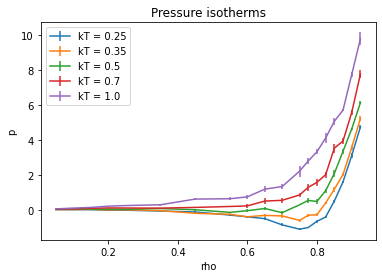

In [29]:
# sweep over temperatures
for kT in kT_range:
        
    filtered_pPot_tr_ens = filterTheDict(pPot_tr_ens_from_NVT_cooling,lambda key : key[2]==str(round(kT,3)) )
    filtered_pKin_tr_ens = filterTheDict(pKin_tr_ens_from_NVT_cooling,lambda key : key[2]==str(round(kT,3)) )
    
    rho_list = []
    p_list = []
    p_error_list = []
    
    for key in sorted(filtered_pPot_tr_ens):
            
        rho_list.append(float(key[1]))
        
        # time average over runs followed by the ensemble average
        p_list.append(
            np.mean(
                np.mean(filtered_pPot_tr_ens[key] +
                        filtered_pKin_tr_ens[key],axis=-1) ) )
        p_error_list.append(
            np.std(
                np.mean(filtered_pPot_tr_ens[key] +
                        filtered_pKin_tr_ens[key],axis=-1) ) / np.sqrt(NTrajectories))
                        
    plt.errorbar(rho_list,p_list,yerr=p_error_list,label="kT = "+str(kT))

plt.xlabel("rho")
plt.ylabel("p")
plt.title("Pressure isotherms")
plt.legend()

### Expanding systems prepared for a range of temperatures

In [30]:
test_list=[1,2,3,4]
test_list[0]

1

In [31]:
# Create empty dictionaries for the data generated by MD simulations at specific state points
t_tr_ens_from_NVT_expanding = {}
x_tr_ens_from_NVT_expanding = {}
y_tr_ens_from_NVT_expanding = {}
vx_tr_ens_from_NVT_expanding = {}
vy_tr_ens_from_NVT_expanding = {}
uPot_tr_ens_from_NVT_expanding = {}
uKin_tr_ens_from_NVT_expanding = {}
pPot_tr_ens_from_NVT_expanding = {}
pKin_tr_ens_from_NVT_expanding = {}
list_of_starting_configurations_from_NVT_expanding = {}


# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

# sweep over temperatures
for kT in kT_range:
    
    # re-initialize starting configurations
    list_of_starting_configurations=[]
    for n in range(NTrajectories): 
            list_of_starting_configurations.append([])    
    

    # sweep over densities
    for rho in np.flipud(rho_range):
        
        print("rho = ",rho,", kT = ",kT)
        
        if list_of_starting_configurations[0]!=[]:
            # rescale old configuration to new box size           
            old_LBox = LBox
            LBox = np.power(NParticles/rho,1./d)
            for n in range(NTrajectories): 
                # x-coordinates
                list_of_starting_configurations[n][1]  *= LBox/old_LBox
                # y-coordinates
                list_of_starting_configurations[n][2]  *= LBox/old_LBox  
        else:
            # starting from scratch, no rescaling
            LBox = np.power(NParticles/rho,1./d)


        # Equilibrate
        # reset velocities more often and hope for the best
        (t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
         uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens,
         list_of_starting_configurations
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_equilibration,
                                                                       list_of_starting_configurations=list_of_starting_configurations,
                                                                       number_of_time_steps_between_velocity_resets=10)

        # using floats as key can lead to difficulties, because of their inexact representation
        key = (NParticles,str(round(rho,3)),str(round(kT,2)))
        
        # Generate data        
        (t_tr_ens_from_NVT_expanding[key], 
         x_tr_ens_from_NVT_expanding[key], 
         y_tr_ens_from_NVT_expanding[key], 
         vx_tr_ens_from_NVT_expanding[key], 
         vy_tr_ens_from_NVT_expanding[key],
         uPot_tr_ens_from_NVT_expanding[key], 
         uKin_tr_ens_from_NVT_expanding[key], 
         pPot_tr_ens_from_NVT_expanding[key], 
         pKin_tr_ens_from_NVT_expanding[key],
         list_of_starting_configurations_from_NVT_expanding[(NParticles,rho,kT)]
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_data_acquisition,
                                                                       list_of_starting_configurations=list_of_starting_configurations)
        

print("Execution time: ",time.perf_counter() - initialWallTime)

rho =  0.9250000000000002 , kT =  0.25
rho =  0.9000000000000001 , kT =  0.25
rho =  0.8750000000000001 , kT =  0.25
rho =  0.8500000000000001 , kT =  0.25
rho =  0.8250000000000001 , kT =  0.25
rho =  0.8 , kT =  0.25
rho =  0.775 , kT =  0.25
rho =  0.75 , kT =  0.25
rho =  0.7000000000000002 , kT =  0.25
rho =  0.6500000000000001 , kT =  0.25
rho =  0.6000000000000001 , kT =  0.25
rho =  0.55 , kT =  0.25
rho =  0.5499999999999999 , kT =  0.25
rho =  0.44999999999999996 , kT =  0.25
rho =  0.35 , kT =  0.25
rho =  0.25 , kT =  0.25
rho =  0.2 , kT =  0.25
rho =  0.15 , kT =  0.25
rho =  0.10000000000000002 , kT =  0.25
rho =  0.07500000000000001 , kT =  0.25
rho =  0.05 , kT =  0.25
rho =  0.9250000000000002 , kT =  0.35
rho =  0.9000000000000001 , kT =  0.35
rho =  0.8750000000000001 , kT =  0.35
rho =  0.8500000000000001 , kT =  0.35
rho =  0.8250000000000001 , kT =  0.35
rho =  0.8 , kT =  0.35
rho =  0.775 , kT =  0.35
rho =  0.75 , kT =  0.35
rho =  0.7000000000000002 , kT =  0

#### Pressure isotherms

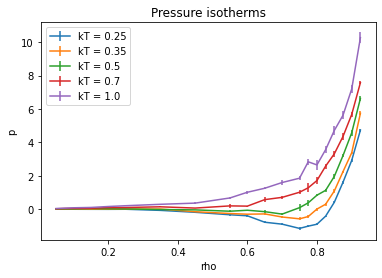

In [32]:
# sweep over temperatures
for kT in kT_range:
        
    filtered_pPot_tr_ens = filterTheDict(pPot_tr_ens_from_NVT_expanding,lambda key : key[2]==str(round(kT,3)) )
    filtered_pKin_tr_ens = filterTheDict(pKin_tr_ens_from_NVT_expanding,lambda key : key[2]==str(round(kT,3)) )
    
    rho_list = []
    p_list = []
    p_error_list = []
    
    for key in sorted(filtered_pPot_tr_ens):
            
        rho_list.append(float(key[1]))
        
        # time average over runs followed by the ensemble average
        p_list.append(
            np.mean(
                np.mean(filtered_pPot_tr_ens[key] +
                        filtered_pKin_tr_ens[key],axis=-1) ) )
        p_error_list.append(
            np.std(
                np.mean(filtered_pPot_tr_ens[key] +
                        filtered_pKin_tr_ens[key],axis=-1) ) / np.sqrt(NTrajectories))
                        
    plt.errorbar(rho_list,p_list,yerr=p_error_list,label="kT = "+str(kT))

plt.xlabel("rho")
plt.ylabel("p")
plt.title("Pressure isotherms")
plt.legend()

### Compressing systems prepared for a range of temperatures

In [33]:
# Create empty dictionaries for the data generated by MD simulations at specific state points
t_tr_ens_from_NVT_compressing = {}
x_tr_ens_from_NVT_compressing = {}
y_tr_ens_from_NVT_compressing = {}
vx_tr_ens_from_NVT_compressing = {}
vy_tr_ens_from_NVT_compressing = {}
uPot_tr_ens_from_NVT_compressing = {}
uKin_tr_ens_from_NVT_compressing = {}
pPot_tr_ens_from_NVT_compressing = {}
pKin_tr_ens_from_NVT_compressing = {}
list_of_starting_configurations_from_NVT_compressing = {}


# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

# sweep over temperatures
for kT in kT_range:
    
    # re-initialize starting configurations
    list_of_starting_configurations=[]
    for n in range(NTrajectories): 
            list_of_starting_configurations.append([])    
    

    # sweep over densities
    for rho in rho_range:
        
        print("rho = ",rho,", kT = ",kT)
        
        if list_of_starting_configurations[0]!=[]:
            # rescale old configuration to new box size           
            old_LBox = LBox
            LBox = np.power(NParticles/rho,1./d)
            for n in range(NTrajectories): 
                # x-coordinates
                list_of_starting_configurations[n][1]  *= LBox/old_LBox
                # y-coordinates
                list_of_starting_configurations[n][2]  *= LBox/old_LBox  
        else:
            # starting from scratch, no rescaling
            LBox = np.power(NParticles/rho,1./d)


        # Equilibrate
        # reset velocities more often and hope for the best
        (t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
         uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens,
         list_of_starting_configurations
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_equilibration,
                                                                       list_of_starting_configurations=list_of_starting_configurations,
                                                                       number_of_time_steps_between_velocity_resets=10)

        # using floats as key can lead to difficulties, because of their inexact representation
        key = (NParticles,str(round(rho,3)),str(round(kT,2)))
        
        # Generate data
        run_time = 1  # outrageously short
        (t_tr_ens_from_NVT_compressing[key], 
         x_tr_ens_from_NVT_compressing[key], 
         y_tr_ens_from_NVT_compressing[key], 
         vx_tr_ens_from_NVT_compressing[key], 
         vy_tr_ens_from_NVT_compressing[key],
         uPot_tr_ens_from_NVT_compressing[key], 
         uKin_tr_ens_from_NVT_compressing[key], 
         pPot_tr_ens_from_NVT_compressing[key], 
         pKin_tr_ens_from_NVT_compressing[key],
         list_of_starting_configurations_from_NVT_compressing[key]
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_data_acquisition,
                                                                       list_of_starting_configurations=list_of_starting_configurations)
        

print("Execution time: ",time.perf_counter() - initialWallTime)

rho =  0.05 , kT =  0.25
rho =  0.07500000000000001 , kT =  0.25
rho =  0.10000000000000002 , kT =  0.25
rho =  0.15 , kT =  0.25
rho =  0.2 , kT =  0.25
rho =  0.25 , kT =  0.25
rho =  0.35 , kT =  0.25
rho =  0.44999999999999996 , kT =  0.25
rho =  0.5499999999999999 , kT =  0.25
rho =  0.55 , kT =  0.25
rho =  0.6000000000000001 , kT =  0.25
rho =  0.6500000000000001 , kT =  0.25
rho =  0.7000000000000002 , kT =  0.25
rho =  0.75 , kT =  0.25
rho =  0.775 , kT =  0.25
rho =  0.8 , kT =  0.25
rho =  0.8250000000000001 , kT =  0.25
rho =  0.8500000000000001 , kT =  0.25
rho =  0.8750000000000001 , kT =  0.25
rho =  0.9000000000000001 , kT =  0.25
rho =  0.9250000000000002 , kT =  0.25
rho =  0.05 , kT =  0.35
rho =  0.07500000000000001 , kT =  0.35
rho =  0.10000000000000002 , kT =  0.35
rho =  0.15 , kT =  0.35
rho =  0.2 , kT =  0.35
rho =  0.25 , kT =  0.35
rho =  0.35 , kT =  0.35
rho =  0.44999999999999996 , kT =  0.35
rho =  0.5499999999999999 , kT =  0.35
rho =  0.55 , kT =  0.

#### Pressure isotherms

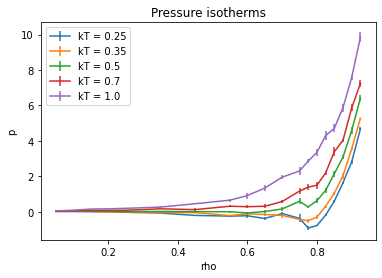

In [34]:
# sweep over temperatures
for kT in kT_range:
        
    filtered_pPot_tr_ens = filterTheDict(pPot_tr_ens_from_NVT_compressing,lambda key : key[2]==str(round(kT,3)) )
    filtered_pKin_tr_ens = filterTheDict(pKin_tr_ens_from_NVT_compressing,lambda key : key[2]==str(round(kT,3)) )
    
    rho_list = []
    p_list = []
    p_error_list = []
    
    for key in sorted(filtered_pPot_tr_ens):
            
        rho_list.append(float(key[1]))
        
        # time average over runs followed by the ensemble average
        p_list.append(
            np.mean(
                np.mean(filtered_pPot_tr_ens[key] +
                        filtered_pKin_tr_ens[key],axis=-1) ) )
        p_error_list.append(
            np.std(
                np.mean(filtered_pPot_tr_ens[key] +
                        filtered_pKin_tr_ens[key],axis=-1) ) / np.sqrt(NTrajectories))
            
    plt.errorbar(rho_list,p_list,yerr=p_error_list,label="kT = "+str(kT))

plt.xlabel("rho")
plt.ylabel("p")
plt.title("Pressure isotherms")
plt.legend()

### Compare results

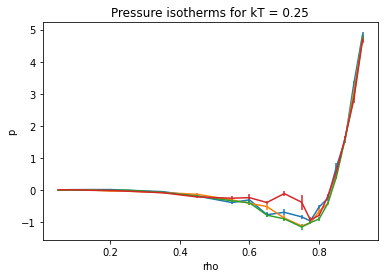

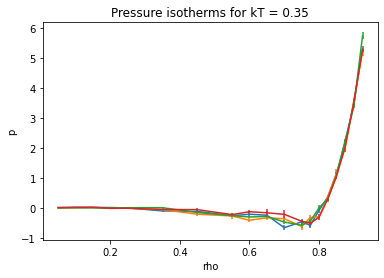

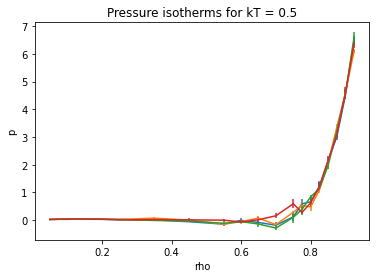

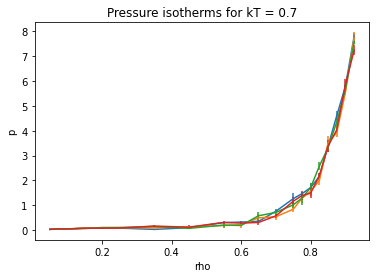

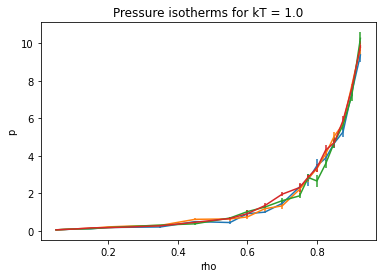

In [35]:
# sweep over temperatures
for kT in kT_range:

    for (pPot_dict,pKin_dict) in [(pPot_tr_ens_from_NVT_heating, pKin_tr_ens_from_NVT_heating),
                                  (pPot_tr_ens_from_NVT_cooling, pKin_tr_ens_from_NVT_cooling),
                                  (pPot_tr_ens_from_NVT_expanding, pKin_tr_ens_from_NVT_expanding),
                                  (pPot_tr_ens_from_NVT_compressing, pKin_tr_ens_from_NVT_compressing)]:
        
        filtered_pPot_tr_ens = filterTheDict(pPot_dict,lambda key : key[2]==str(round(kT,3)) )
        filtered_pKin_tr_ens = filterTheDict(pKin_dict,lambda key : key[2]==str(round(kT,3)) )
    
        rho_list = []
        p_list = []
        p_error_list = []
    
        for key in sorted(filtered_pPot_tr_ens):
            
            rho_list.append(float(key[1]))
            # time average over runs followed by the ensemble average
            p_list.append(
                np.mean(
                    np.mean(filtered_pPot_tr_ens[key] +
                            filtered_pKin_tr_ens[key],axis=-1) ) )
            p_error_list.append(
                np.std(
                    np.mean(filtered_pPot_tr_ens[key] +
                            filtered_pKin_tr_ens[key],axis=-1) ) / np.sqrt(NTrajectories))
            
        plt.errorbar(rho_list,p_list,yerr=p_error_list)

    plt.xlabel("rho")
    plt.ylabel("p")
    plt.title("Pressure isotherms for kT = "+str(kT))
    plt.show()